<a href="https://colab.research.google.com/github/hungryPanko/SignalDetection/blob/main/signalDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement 

Multi-task learning

(Regression) Predict a bounding box around the road sign

(Classification) Identify the type of road sign (4 classes)
- Traffic Light
- Stop
- Speed Limit
- Crosswalk

In [ ]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms.functional as TF

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/SignalDetection

torch.cuda.is_available()  # Go to Menu > Runtime > Change runtime to GPU
images_path = Path('./input/images')
anno_path = Path('./input/annotations')

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/SignalDetection


In [ ]:
"""
images_path = Path('./input/images')
anno_path = Path('./input/annotations')

def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)
"""

'\nimages_path = Path(\'./input/images\')\nanno_path = Path(\'./input/annotations\')\n\ndef filelist(root, file_type):\n    return [os.path.join(directory_path, f) for directory_path, directory_name, \n            files in os.walk(root) for f in files if f.endswith(file_type)]\n\ndef generate_train_df (anno_path):\n    annotations = filelist(anno_path, \'.xml\')\n    anno_list = []\n    for anno_path in annotations:\n        root = ET.parse(anno_path).getroot()\n        anno = {}\n        anno[\'filename\'] = Path(str(images_path) + \'/\'+ root.find("./filename").text)\n        anno[\'width\'] = root.find("./size/width").text\n        anno[\'height\'] = root.find("./size/height").text\n        anno[\'class\'] = root.find("./object/name").text\n        anno[\'xmin\'] = int(root.find("./object/bndbox/xmin").text)\n        anno[\'ymin\'] = int(root.find("./object/bndbox/ymin").text)\n        anno[\'xmax\'] = int(root.find("./object/bndbox/xmax").text)\n        anno[\'ymax\'] = int(root.fi

In [ ]:
"""
# create dataframe
df_train = generate_train_df(anno_path)
df_train['class'].value_counts()
"""

"\n# create dataframe\ndf_train = generate_train_df(anno_path)\ndf_train['class'].value_counts()\n"

In [ ]:
"""
#target is encoded to numeric. 
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['label'] = df_train['class'].apply(lambda x:  class_dict[x])
df_train['label'].value_counts()
"""

"\n#target is encoded to numeric. \nclass_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}\ndf_train['label'] = df_train['class'].apply(lambda x:  class_dict[x])\ndf_train['label'].value_counts()\n"

In [ ]:
#------
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    # Creates a mask for the bounding box of same shape as image
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    #Y = np.zeros((rows, cols), dtype='uint8')
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    # Convert mask Y to a bounding box, assumes 0 as background nonzero object
    #if(Y.shape is not (300,300)):
    #    print(Y.shape)
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    # Generates bounding box array from a train_df row
    return np.array([x[5],x[4],x[7],x[6]]) # ymin xmin ymax xmax

def resize_image_bb(read_path, write_path, bb, sz):
    # Resize an image and its bounding box and write image to new path
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)


In [ ]:
"""
IM_SIZE = 300
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)

for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs
df_train.head()
"""

"\nIM_SIZE = 300\nnew_paths = []\nnew_bbs = []\ntrain_path_resized = Path('./images_resized')\nPath.mkdir(train_path_resized, exist_ok=True)\n\nfor index, row in df_train.iterrows():\n    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)\n    new_paths.append(new_path)\n    new_bbs.append(new_bb)\n    \ndf_train['new_path'] = new_paths\ndf_train['new_bb'] = new_bbs\ndf_train.head()\n"

In [ ]:
#df_train.to_pickle("./savepoint3.pkl") 
df_train = pd.read_pickle("./savepoint1.pkl") 
df_train = df_train.drop(columns=['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax'])

In [ ]:
df_train

,class,label,new_path,new_bb
0,trafficlight,3,images_resized/road10.png,"[3.0, 80.0, 295.0, 182.0]"
1,trafficlight,3,images_resized/road0.png,"[46.0, 110.0, 173.0, 233.0]"
2,trafficlight,3,images_resized/road1.png,"[67.0, 116.0, 297.0, 192.0]"
3,speedlimit,0,images_resized/road112.png,"[13.0, 103.0, 170.0, 203.0]"
4,speedlimit,0,images_resized/road113.png,"[42.0, 128.0, 203.0, 229.0]"
...,...,...,...,...
872,speedlimit,0,images_resized/road540.png,"[203.0, 145.0, 231.0, 182.0]"
873,speedlimit,0,images_resized/road703.png,"[95.0, 214.0, 131.0, 248.0]"
874,speedlimit,0,images_resized/road670.png,"[109.0, 129.0, 153.0, 188.0]"
875,speedlimit,0,images_resized/road775.png,"[97.0, 109.0, 127.0, 149.0]"


In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    #return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color, fill=False, lw=3)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

images_resized/road110.png
img size: (300, 300, 3)
bb: [ 11. 147. 202. 282.]


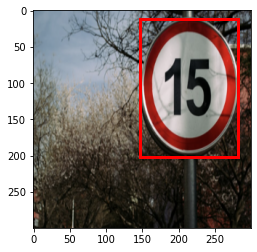

In [ ]:
# Test for drawing img and bounding box
n = 8
path = df_train['new_path'].values[n]
bb = df_train['new_bb'].values[n]
label = df_train['class'].values[n]

im = cv2.imread(str(path))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, bb)
print(str(path))
print("img size: "+str(im.shape))
print("bb: "+str(bb))

In [ ]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

def seg_transform(im_path, bb, transform=False):
    # load image
    image = Image.open(im_path)
    # create mask 
    rows,cols,*_ = image.size
    bb = bb.astype(int)
    seg_arr = np.zeros((rows, cols))
    seg_arr[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    seg_mask = Image.fromarray(seg_arr)
    # Perform transform
    if transform:
        # Random rotation
        rdeg = (np.random.random()-.50)*20
        image    = TF.rotate(image,    rdeg)
        seg_mask = TF.rotate(seg_mask, rdeg)
        # Random flip
        if np.random.random() > 0.5: 
            image    = TF.hflip(image)
            seg_mask = TF.hflip(seg_mask)
        # Random crop
        v_crop = (np.random.random()*8)
        h_crop = (np.random.random()*8)
        image    = TF.resized_crop(image,    v_crop, h_crop, rows-(2*v_crop), cols-(2*h_crop), (rows,cols))
        seg_mask = TF.resized_crop(seg_mask, v_crop, h_crop, rows-(2*v_crop), cols-(2*h_crop), (rows,cols))
    # Return (potentially) transformed image
    return image, mask_to_bb(seg_mask)

img size: (300, 300)
bb: [  7.  10. 204. 153.]


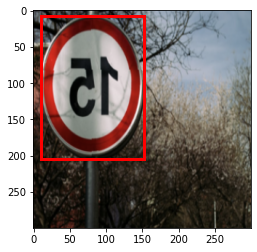

In [ ]:
# Test for Data Aug
x, y_bb = seg_transform(path, bb, transform=True) # Pillow Image
show_corner_bb(x, y_bb)
print("img size: "+str(x.size)) 
print("bb: "+str(y_bb))

In [ ]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = seg_transform(path, self.bb[idx], transform=self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [ ]:
# Split to Train / Valid 
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']] # new_bb: ymin, xmin, ymax, xmax, 
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Transform Dataset 
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'], y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

# batch_size = 64
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
# Display image and label.
train_features, train_labels, train_bb = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"bb batch shape: {train_bb.len()}")
print(train_labels)
label = train_labels
print(f"Label: {label}")
print(train_bb)

img = train_features[0].permute(1, 2, 0)
print(img.shape)
bb = list(np.concatenate(train_bb).flat)
print(bb)
show_corner_bb(img,bb)

Feature batch shape: torch.Size([16, 3, 300, 300])


AttributeError: ignored

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*300*300, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb         = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        label = self.classifier(x)
        bb = self.bb(x)
        return label, bb

In [ ]:
# Pytorch
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb         = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        label = self.classifier(x)
        bb = self.bb(x)
        return label, bb

In [ ]:
class ToDo(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        pass

    def forward(self, x):
        label = []
        bb = []
        pass
        return label, bb

In [ ]:
# Training
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
        #for x, y_class, y_bb in tqdm(train_dl):
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)

            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

#Eval
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [ ]:
#model = SimpleCNN().cuda()
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
model

BB_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

AttributeError: ignored

In [ ]:
# resizing test image
im = cv2.imread('./images_resized/road21.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road21.jpg',im)

# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':'./road_signs_test/road21.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape


In [ ]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

In [ ]:
# predicted class
print(f'Test image prediction: {torch.max(out_class, 1)}')

# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(cv2.cvtColor(im, cv2.COLOR_RGB2BGR), bb_hat[0])
plt.show()